In [1]:
import xlwings as xw
import pandas as pd

from Options_Math_Helpers import *
from Options_Math_Algebra import *
from Options_Math_Black_Scholes import *
from Options_Wow_Alpha_Skew import *

omh  = OptionsMathHelpers()
oma  = OptionsMathAlgebra()
ombs = OptionsMathBlackScholes()
wa   = WowAlphaSkew()

In [2]:
# Open workbook
wb = xw.Book('deribit.xlsx')

# Select sheet by name
sheet = wb.sheets['enriched']

# Read entire used range into a DataFrame
df = sheet.used_range.options(pd.DataFrame, header=True, index=False).value

In [3]:
cols = ['instrument_name', 
        'option_type', 
        'strike', 
        'expiration_time_nyc', 
        'years_to_expiry', 
        'underlying_price',
        'mark_price', 
        'greeks_vega',
        'enriched_bid_price', 
        'enriched_ask_price',
        'enriched_mid_price',
        'enriched_bid_iv', 
        'enriched_ask_iv',
        'enriched_mid_iv'
       ]

df = df.loc[:, [c for c in cols if c in df.columns]]

print('done')

done


In [4]:
#df['vega'] = ombs.bs_vega(fwd=df['underlying_price'], 
 #                         strike=df['strike'], 
  #                        time=df['years_to_expiry'],
   #                       vol=df['enriched_mid_iv']/100) 

In [5]:
exp_list = df['years_to_expiry'].unique()

In [6]:
initial_wow  = 0.4
initial_conv = -0.1

len = 0.0

In [23]:
list_of_dicts = []

for exp in (x for x in exp_list if x > len):
    mask = df['years_to_expiry'] == exp 

    fwds = df.loc[mask, 'underlying_price']
    strikes = df.loc[mask, 'strike']
    times = df.loc[mask, 'years_to_expiry']
    vols = df.loc[mask, 'enriched_mid_iv'] / 100
    vegas = df.loc[mask, 'greeks_vega']
    target_values = df.loc[mask, 'enriched_mid_price']
    opt_types = omh.option_type(df.loc[mask, 'option_type'], strikes)

    fwd_val = fwds.mean()
    atm_vol = np.interp(fwd_val, strikes, vols) 

    wow, convexity, result = wa.calibrate_wow_alpha_weighted(opt_type=opt_types, 
                                                             fwd=fwds, 
                                                             strike=strikes, 
                                                             time=times, 
                                                             vol_atm=atm_vol,
                                                             target_value=target_values, 
                                                             weighting='vega',
                                                             weight=vegas,
                                                             initial_guess=(initial_wow, initial_conv),
                                                             bounds=([-10, -10], [10, 10]))

    dict_of_results = {'exp' : exp, "wow" : wow, 'conv' : convexity}
    list_of_dicts.append(dict_of_results)

    df.loc[mask, 'model_price'] = wa.wow_alpha_value(opt_type=opt_types, fwd=fwds, strike=strikes, time=times, 
                                           vol_atm=atm_vol, wow=wow, convexity=convexity)

results_df = pd.DataFrame(list_of_dicts)
print(results_df)

         exp       wow      conv
0   0.000459  0.319049 -9.274169
1   0.003197  0.351259 -4.203926
2   0.005935  0.324578 -3.124340
3   0.008673  0.301441 -2.599905
4   0.025100  0.332550 -1.555966
5   0.044265  0.356317 -1.062043
6   0.101760  0.349632 -0.632048
7   0.197584  0.343537 -0.394847
8   0.350904  0.362076 -0.257426
9   0.600049  0.361648 -0.155300
10  0.849193  0.366850 -0.096468


In [43]:
import matplotlib.pyplot as plt

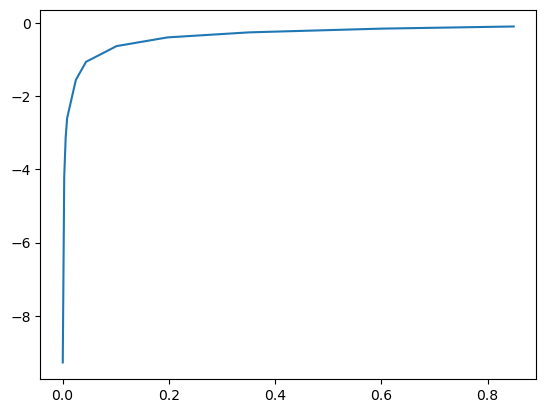

In [44]:
x = results_df['exp']
y = results_df['conv']

plt.plot(x, y)
plt.show()

In [53]:
from scipy.optimize import curve_fit

def model(params, x):
    a1, b1, a2, b2, c = params
    return c + a1*np.exp(-b1*x) + a2*np.exp(-b2*x)

def residuals(params, x, y):
    return y - model(params, x)

x = results_df['exp'].values
y = results_df['conv'].values

p0 = [-9, 200, -1, 2, 0]   # reasonable starting guess
results = least_squares(residuals, p0, args=(x,y))
a1, b1, a2, b2, c = results.x

print("a1 b1 a2 b2 c =", result.x)

results_df['model_conv'] = model(results.x, x)

print(results_df)

a1 b1 a2 b2 c = [-7.90731590e+00  5.62241790e+02 -2.93967251e+00  2.90615657e+01
 -2.60605317e-01]
         exp       wow      conv  model_conv
0   0.000459  0.319049 -9.274169   -9.269282
1   0.003197  0.351259 -4.203926   -4.249758
2   0.005935  0.324578 -3.124340   -3.015657
3   0.008673  0.301441 -2.599905   -2.605650
4   0.025100  0.332550 -1.555966   -1.678057
5   0.044265  0.356317 -1.062043   -1.072725
6   0.101760  0.349632 -0.632048   -0.413348
7   0.197584  0.343537 -0.394847   -0.270036
8   0.350904  0.362076 -0.257426   -0.260715
9   0.600049  0.361648 -0.155300   -0.260605
10  0.849193  0.366850 -0.096468   -0.260605


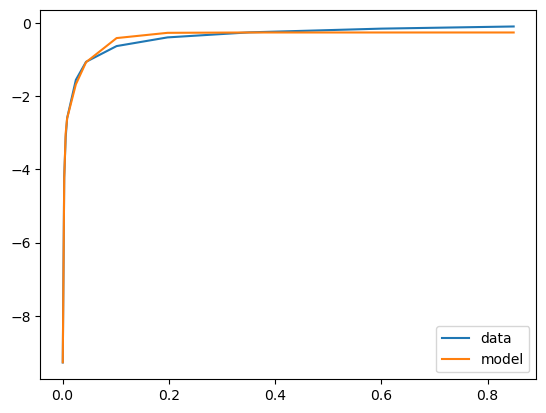

In [54]:
x = results_df['exp']
y = results_df['conv']
z = results_df['model_conv']

plt.plot(x, y, label="data")
plt.plot(x, z, label="model")

plt.legend()
plt.show()

In [12]:
sheet = wb.sheets('wow_alpha')
sheet.range('a1').options(index = False, header=1).value = df